In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from PIL import Image, ImageOps

import random 
from skimage import io
import matplotlib.pyplot as plt

In [9]:
dir_path="/content/drive/MyDrive/dataset_basura"
classes = ["botelleas_vidrio"]
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{dir_path}/{lab}')
  if lab in ['botelleas_vidrio']:
    print(f'Categoría: {lab}. Imágenes: {len(paths)}')
    paths = [p for p in paths if p[-3:] == "jpg"]
    imgs += [f'{dir_path}/{lab}/{img}' for img in paths]
    labels += [i]*len(paths)

Categoría: botelleas_vidrio. Imágenes: 1006


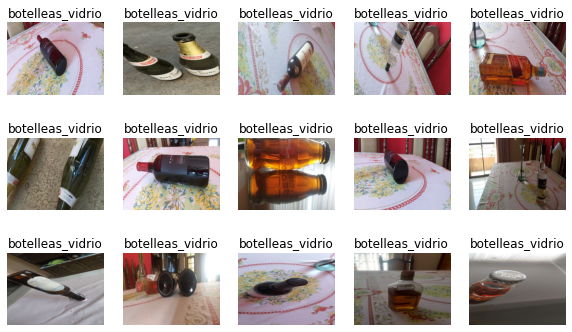

In [11]:
def graficar():
  fig, axs = plt.subplots(3,5, figsize=(10,6))
  for _ax in axs:
    for ax in _ax:
      ix = random.randint(0, len(imgs)-1)
      img = io.imread(imgs[ix])
      ax.imshow(img)
      ax.axis('off')
      ax.set_title(classes[labels[ix]])
  plt.show()
graficar()

In [12]:
imagenes = [ImageOps.grayscale(Image.open(i).resize((60,60))) for i in imgs]

In [13]:
#imagenes = [Image.open(i).resize((224,224)) for i in imgs]

In [14]:
class Generator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100

    self.inp = torch.nn.Sequential(
        torch.nn.Linear(self.input_size, 15*15*128),
        torch.nn.BatchNorm1d(15*15*128),
    )
    self.main = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        # torch.nn.BatchNorm2d(64),
        # torch.nn.ReLU(True),
        # torch.nn.ConvTranspose2d(64, 1, 4, stride=1, padding=1, bias=False),
        #torch.nn.ConvTranspose2d(64, 1, 4, stride=1, padding=1, bias=False),
        torch.nn.Tanh()
    )

  def forward(self, x):
    #print("Dimensiones:")
    #print("Entrada: ", x.shape)
    x = self.inp(x)
    #print("Entrada: ", x.shape)
    x = x.view(-1, 128, 15, 15)
    #print("Entrada: ", x.shape)
    x = self.main(x)
    #print("Entrada: ", x.shape)
    x = x.view(x.size(0), 60*60)
    #print("Entrada: ", x.shape)
    return x

In [15]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, imagenes, labels):
    self.imgs = torch.tensor([np.array(i).flatten() / 255. for i in imagenes], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i for i in labels], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(imagenes, labels)
len(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


1006

In [16]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 3600]), torch.Size([32]))

In [17]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.main = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(True)
    )
    self.out = torch.nn.Sequential(
        torch.nn.Linear(128*15*15, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 28*28
    #print("Dimensiones:")
    #print("Entrada: ", x.shape)
    x = x.view(x.size(0), 1, 60, 60)
    #print("Entrada: ", x.shape)
    x = self.main(x)
    #print("Entrada: ", x.shape)
    x = x.view(x.size(0), -1)
    #print("Entrada: ", x.shape)
    x = self.out(x)
    #print("Entrada: ", x.shape)
    return x

In [29]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=15, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-7)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-7)
  crit = torch.nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [30]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 3600])

In [31]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 60*60))
output.shape

torch.Size([64, 1])

In [ ]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(),epochs=80)

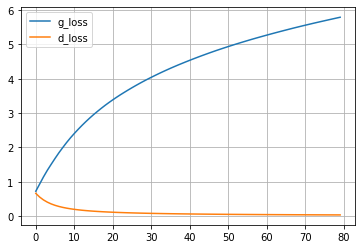

In [22]:
import pandas as pd 
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

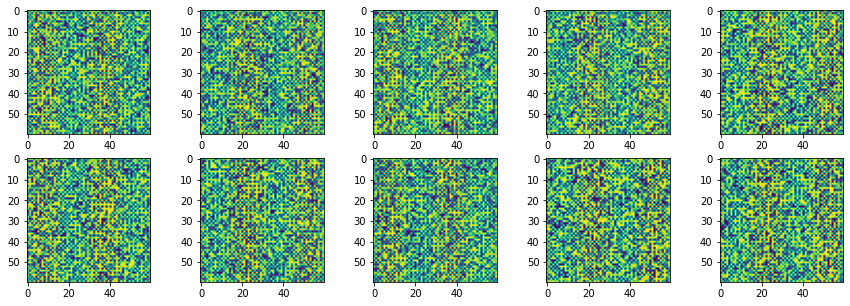

In [23]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(60,60).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

# con transfer learning

In [24]:
# import torchvision

# resnet = torchvision.models.resnet18()
# resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# class Model(torch.nn.Module):
#   def __init__(self, n_outputs=1, pretrained=False, freeze=False):
#     super().__init__()
#     # descargamos resnet
#     resnet = torchvision.models.resnet18(pretrained=pretrained)
#     # nos quedamos con todas las capas menos la última
#     self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
#     if freeze:
#       for param in self.resnet.parameters():
#         param.requires_grad=False
#     # añadimos una nueva capa lineal para llevar a cabo la clasificación
#     self.fc = torch.nn.Linear(512, 1)

#   def forward(self, x):
#     x = self.resnet(x)
#     x = x.view(x.shape[0], -1)
#     x = self.fc(x)
#     return x

#   def unfreeze(self):
#     for param in self.resnet.parameters():
#         param.requires_grad=True

In [26]:
# discriminador = Model()
# outputs = discriminador(torch.randn(64, 3, 224, 224))
# outputs.shape

torch.Size([64, 1])

In [27]:
# generator = Model()
# output = generator(torch.randn(64, 3,224,224))
# output.shape

torch.Size([64, 1])